In [1]:
import numpy as np
import h5py
from scipy.signal import butter, filtfilt, iirnotch

## Data Preprocess

### read .mat data

In [2]:
with h5py.File('./Dataset/increasingforce1.mat', 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    # Get the data
    increase_grid_one = file['grid_crds'][()].T
    increase_mat_one = file['out_mat'][()].T
    
with h5py.File('./Dataset/increasingforce2.mat', 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    # Get the data
    increase_grid_two = file['grid_crds'][()].T
    increase_mat_two = file['out_mat'][()].T
    
with h5py.File('./Dataset/steadyforce.mat', 'r') as file:
    # List all groups
    print("Keys: %s" % file.keys())
    # Get the data
    steady_grid = file['grid_crds'][()].T
    steady_mat = file['out_mat'][()].T

Keys: <KeysViewHDF5 ['grid_crds', 'out_mat']>
Keys: <KeysViewHDF5 ['grid_crds', 'out_mat']>
Keys: <KeysViewHDF5 ['grid_crds', 'out_mat']>


### filter out noise using filt_GRID

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a
def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out

In [4]:
filted_increase_mat_one = filt_GRID(increase_mat_one)
filted_increase_mat_two = filt_GRID(increase_mat_two)
filted_steady_mat = filt_GRID(steady_mat)

In [5]:
steady_mat.shape

(64, 73214)

In [6]:
steady_mat.shape

(64, 73214)

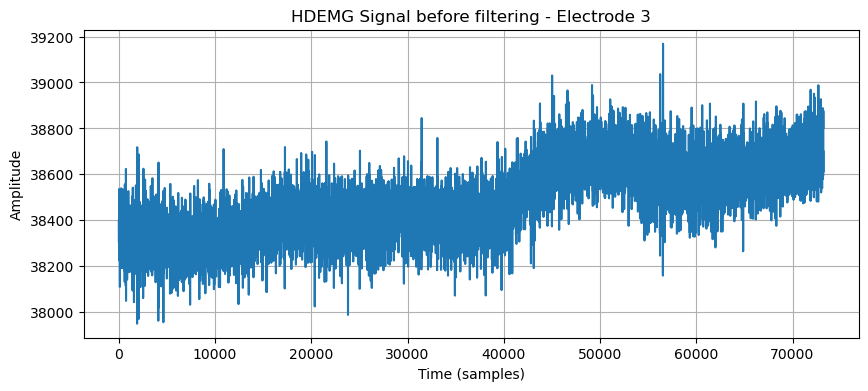

In [7]:
import matplotlib.pyplot as plt

# Plot the HDEMG signals from one electrode over time
electrode_index = 3  # Change to the index of the electrode you want to visualize
plt.figure(figsize=(10, 4))
plt.plot(steady_mat[electrode_index, :])
plt.title(f'HDEMG Signal before filtering - Electrode {electrode_index}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

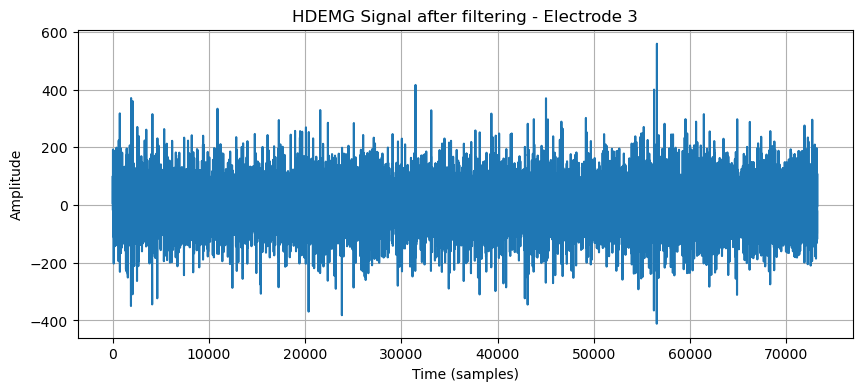

In [8]:
import matplotlib.pyplot as plt

# Plot the HDEMG signals from one electrode over time
electrode_index = 3  # Change to the index of the electrode you want to visualize
plt.figure(figsize=(10, 4))
plt.plot(filted_steady_mat[electrode_index, :])
plt.title(f'HDEMG Signal after filtering - Electrode {electrode_index}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [10]:
np.savetxt(
    './preprocessed_data/' + 'increase_mat_one.csv',
    filted_increase_mat_one, 
    delimiter=','
)

np.savetxt(
    './preprocessed_data/' + 'increase_mat_two.csv',
    filted_increase_mat_two,
    delimiter=','
)

np.savetxt(
    './preprocessed_data/' + 'steady_mat.csv',
    filted_steady_mat,
    delimiter=','
)


# Preprocess end

In [10]:
import numpy as np
from sklearn.decomposition import FastICA

def apply_ica(data, num_components):
    # Initialize ICA
    ica = FastICA(n_components=num_components, random_state=0)
    # Fit and transform the data to the ICA model
    S_ = ica.fit_transform(data)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    
    return S_, A_

# Assuming the number of electrodes gives an upper limit on components
num_components = increase_mat_one.shape[0]
 
# Apply ICA to each dataset
S_increase_one, A_increase_one = apply_ica(filted_increase_mat_one, num_components)
S_increase_two, A_increase_two = apply_ica(filted_increase_mat_two, num_components)
S_steady, A_steady = apply_ica(filted_steady_mat, num_components)


In [11]:
def extract_features(component):
    # Placeholder function to extract features like amplitude, duration, etc.
    features = {
        'amplitude': np.ptp(component),
        # Add more features here
    }
    return features

def validate_component(features):
    # Placeholder function for validation based on features
    is_valid = True  # Change this based on actual criteria
    # Example: Check amplitude range
    if not (5 <= features['amplitude'] <= 200):
        is_valid = False
    # Add more criteria here
    return is_valid

# Now apply these to your components
valid_components = []
for i, component in enumerate(S_increase_one):
    features = extract_features(component)
    if validate_component(features):
        valid_components.append(component)

# Now 'valid_components' holds components that passed the validation


In [12]:
def score_temporal_independence(component, other_components):
    # Placeholder for scoring temporal independence.
    # Could use cross-correlation as one possible method.
    return score

def score_physiological_plausibility(component):
    # Score based on frequency content, shape, amplitude, etc.
    return score

def score_stability_across_contractions(component, other_levels):
    # Compare this component to its manifestations at other contraction levels.
    return score

def is_valid_motor_unit(component, other_components, other_levels):
    temp_score = score_temporal_independence(component, other_components)
    physio_score = score_physiological_plausibility(component)
    stability_score = score_stability_across_contractions(component, other_levels)
    
    # These thresholds would be based on empirical data and expert input
    if temp_score > temporal_independence_threshold and \
       physio_score > physiological_plausibility_threshold and \
       stability_score > stability_threshold:
        return True
    else:
        return False


In [16]:
def calculate_cross_correlation(component, other_components):
    # This function should calculate the cross-correlation of the component with all other components
    # and return the maximum correlation value as the metric
    max_correlation = 0
    for other in other_components:
        correlation = np.corrcoef(component, other)[0, 1]  # Assuming component data are numpy arrays
        max_correlation = max(max_correlation, abs(correlation))
    return max_correlation


In [21]:
def calculate_firing_rate(component, threshold=0.5, fs=1000):
    """
    Calculate the firing rate of a motor unit based on its action potentials.
    
    Args:
    - component: The ICA component representing the motor unit's activity.
    - threshold: A value above which the component's signal is considered a spike.
    - fs: Sampling frequency.
    
    Returns:
    - firing_rate: The firing rate in Hertz (spikes per second).
    """
    # Detect spikes: this is a simple threshold-based method, you might need a more complex algorithm
    spikes = component > threshold
    # Find the indices of the spike peaks
    spike_peaks = np.where((spikes[:-1] == False) & (spikes[1:] == True))[0] + 1
    # Calculate inter-spike intervals (ISI) in seconds
    isi = np.diff(spike_peaks) / fs
    # Calculate the firing rate as the reciprocal of the ISI
    if len(isi) > 0:
        firing_rate = 1 / np.mean(isi)
    else:
        firing_rate = 0
    return firing_rate

# Update the stability score function with the new calculate_firing_rate function
def calculate_stability_score(component, fs=1000):
    # Calculate the firing rate using the implemented function
    firing_rate = calculate_firing_rate(component, fs=fs)
    # Inverse of the variance could be a measure of stability
    score = 1 / np.var(firing_rate) if firing_rate > 0 else 0
    return score


def calculate_physiological_score(component):
    # This function should assess the physiological plausibility of the component
    # For demonstration, let's assume it returns a score based on the component's peak-to-peak amplitude
    peak_to_peak_amplitude = np.ptp(component)  # This is a simple proxy for demonstration
    score = peak_to_peak_amplitude / some_reference_value  # 'some_reference_value' needs to be defined
    return score


# Replace 'some_reference_value' with an appropriate value for your analysis
some_reference_value = 1.0  # Example placeholder value

# Now you would use these functions in your validation logic
def validate_components(components, temporal_independence_threshold, physiological_plausibility_threshold, stability_threshold):
    valid_components = []
    for component in components:
        temp_indep_score = calculate_cross_correlation(component, components)
        physio_score = calculate_physiological_score(component)
        stability_score = calculate_stability_score(component)
        
        # Check if all scores are above their respective thresholds
        if temp_indep_score < temporal_independence_threshold and \
           physio_score > physiological_plausibility_threshold and \
           stability_score > stability_threshold:
            valid_components.append(component)
            
    return valid_components

# Now apply the validation function
valid_increase_one = validate_components(S_increase_one, temporal_independence_threshold, physiological_plausibility_threshold, stability_threshold)
valid_increase_two = validate_components(S_increase_two, temporal_independence_threshold, physiological_plausibility_threshold, stability_threshold)
valid_steady = validate_components(S_steady, temporal_independence_threshold, physiological_plausibility_threshold, stability_threshold)


/var/folders/rz/l50w_ggd3ql731df3bxtvb7h0000gn/T/ipykernel_7071/4172068092.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  score = 1 / np.var(firing_rate) if firing_rate > 0 else 0


In [22]:
num_motor_units_one = len(valid_increase_one)
num_motor_units_two = len(valid_increase_two)
num_motor_units_steady = len(valid_steady)

print(f"Number of motor units in increase_mat_one: {num_motor_units_one}")
print(f"Number of motor units in increase_mat_two: {num_motor_units_two}")
print(f"Number of motor units in steady_mat: {num_motor_units_steady}")


Number of motor units in increase_mat_one: 0
Number of motor units in increase_mat_two: 0
Number of motor units in steady_mat: 0


In [23]:
import matplotlib.pyplot as plt

# Plot some of the valid components
def plot_components(components, num_to_plot):
    plt.figure(figsize=(15, 7))
    for i, component in enumerate(components[:num_to_plot]):
        plt.subplot(num_to_plot, 1, i + 1)
        plt.plot(component)
        plt.title(f'Component {i}')
    plt.tight_layout()
    plt.show()

plot_components(valid_increase_one, 5)  # Plot 5 components as an example


<Figure size 1500x700 with 0 Axes>